In [1]:
import sys, os, time, pickle
from timeit import default_timer as timer
from humanfriendly import format_timespan

In [2]:
import pandas as pd
import numpy as np

In [3]:
from dotenv import load_dotenv
load_dotenv('admin.env')

True

In [41]:
from db_connect_mag import Session, Paper, PaperAuthorAffiliation, db

In [5]:
# test_papers_df = pd.read_pickle('data/collect_haystack_20180409/test_papers.pickle')
# target_papers_df = pd.read_pickle('data/collect_haystack_20180409/target_papers.pickle')
# train_papers_df = pd.read_pickle('data/collect_haystack_20180409/train_papers.pickle')

In [6]:
# this is the data for the fortunato review on Community Detection in Graphs
start = timer()
test_papers_df = pd.read_pickle('data/collect_haystack_20180409_2/test_papers.pickle')
target_papers_df = pd.read_pickle('data/collect_haystack_20180409_2/target_papers.pickle')
train_papers_df = pd.read_pickle('data/collect_haystack_20180409_2/train_papers.pickle')
print(format_timespan(timer()-start))

4.97 seconds


In [7]:
with open('data/collect_haystack_20180409_2/counter.pickle', 'rb') as f:
    c = pickle.load(f)

In [8]:
# with open('data/collect_haystack_2490420619/counter_checkpoint.pickle', 'rb') as f:
#     c = pickle.load(f)

In [9]:
def get_target_in_test(test, target, id_colname='Paper_ID'):
    return set.intersection(set(test[id_colname]), set(target[id_colname]))
len(get_target_in_test(test_papers_df, target_papers_df))

397

In [10]:
len(target_papers_df)

397

In [11]:
len(test_papers_df)

2613341

In [12]:
# remove the train (seed) papers from the test set (haystack)
n_before = len(test_papers_df)
test_papers_df = test_papers_df.drop(train_papers_df.index, errors='ignore')
n_after = len(test_papers_df)
print("removed {} seed papers from the haystack. size of haystack: {}".format(n_before-n_after, n_after))

removed 50 seed papers from the haystack. size of haystack: 2613291


In [13]:
start = timer()
target_ids = set(target_papers_df.Paper_ID)
test_papers_df['target'] = test_papers_df.Paper_ID.apply(lambda x: x in target_ids)
print(format_timespan(timer()-start))

0.6 seconds


In [14]:
# def tree_distance(n1, n2, sep=":"):
#     # https://en.wikipedia.org/wiki/Lowest_common_ancestor
#     # the distance from v to w can be computed as 
#     # the distance from the root to v, plus the distance from 
#     # the root to w, minus twice the distance from 
#     # the root to their lowest common ancestor
#     v, w = [n.split(sep) for n in [n1, n2]]
#     distance_root_to_v = len(v)
#     distance_root_to_w = len(w)
    
#     distance_root_to_lca = 0
#     for i in range(min(distance_root_to_v, distance_root_to_w)):
#         if v[i] == w[i]:
#             distance_root_to_lca += 1
#         else:
#             break
#     return distance_root_to_v + distance_root_to_w - (2*distance_root_to_lca)

In [15]:
def tree_distance(n1, n2, sep=":"):
    # since depth is sort of arbitrary, let's try this
    v, w = [n.split(sep) for n in [n1, n2]]
    distance_root_to_v = len(v)
    distance_root_to_w = len(w)
    avg_depth = (distance_root_to_v + distance_root_to_w) * .5
    
    distance_root_to_lca = 0
    for i in range(min(distance_root_to_v, distance_root_to_w)):
        if v[i] == w[i]:
            distance_root_to_lca += 1
        else:
            break
    return (avg_depth - distance_root_to_lca) / avg_depth

In [16]:
def avg_distance(cl, cl_group):
    distances = []
    for x in cl_group:
        distances.append(tree_distance(cl, x))
    return sum(distances) / len(distances)

In [17]:
start = timer()
test_papers_df['avg_distance_to_train'] = test_papers_df.cl.apply(avg_distance, cl_group=train_papers_df.cl.tolist())
print(format_timespan(timer()-start))

5 minutes and 49.06 seconds


In [18]:
test_papers_df.sort_values(['avg_distance_to_train', 'EF'], ascending=[True, False]).head(50)

,EF,Paper_ID,cl,title,year,target,avg_distance_to_train
107272,1.992670e-06,2095293504,3372652:1:1:2,finding and evaluating community structure in ...,2004.0,False,0.611111
110154,9.501080e-07,2131681506,3372652:1:1:9,fast unfolding of communities in large networks,2008.0,False,0.611111
109495,8.579680e-07,2120043163,3372652:1:1:7,comparing community structure identification,2005.0,False,0.611111
114759,3.484730e-07,2606584716,3372652:1:1:29,e mail as spectroscopy automated discovery of ...,2005.0,False,0.611111
110902,8.711380e-08,2139818818,3372652:1:1:55,mixture models and exploratory analysis in net...,2007.0,False,0.611111
107228,8.128820e-08,2091202730,3372652:1:1:52,detect overlapping and hierarchical community ...,2009.0,False,0.611111
109443,6.873940e-08,2117526408,3372652:1:1:68,towards real time community detection in large...,2009.0,False,0.611111
118641,2.728230e-08,1967752035,3372652:1:1:148,finding instabilities in the community structu...,2005.0,False,0.611111
123223,2.550930e-08,2033507223,3372652:1:1:128,quantifying and identifying the overlapping co...,2009.0,False,0.611111
106490,2.393100e-08,2069629462,3372652:1:1:170,comparison and validation of community structu...,2006.0,False,0.611111


In [19]:
test_papers_df.groupby('target')['EF', 'avg_distance_to_train'].describe().T

target                              False         True 
EF                    count  2.612894e+06  3.970000e+02
                      mean   3.942335e-08  9.342797e-07
                      std    3.210841e-07  2.630972e-06
                      min    5.434740e-09  7.338580e-09
                      25%    5.717760e-09  2.819180e-08
                      50%    7.594130e-09  9.191400e-08
                      75%    1.667440e-08  4.857660e-07
                      max    1.716360e-04  2.707530e-05
avg_distance_to_train count  2.612894e+06  3.970000e+02
                      mean   9.971833e-01  8.228729e-01
                      std    2.735958e-02  1.772978e-01
                      min    6.111111e-01  6.161111e-01
                      25%    1.000000e+00  6.161111e-01
                      50%    1.000000e+00  8.505556e-01
                      75%    1.000000e+00  1.000000e+00
                      max    1.000000e+00  1.000000e+00

In [20]:
import matplotlib.pyplot as plt

In [21]:
%matplotlib inline

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [109]:
X = test_papers_df[['EF', 'avg_distance_to_train']]
y = test_papers_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

In [110]:
start = timer()
model = LogisticRegression()
model.fit(X_train, y_train)
print(format_timespan(timer()-start))

6.36 seconds


In [111]:
# y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_proba = model.predict_proba(X)[:, 1]
y_pred_proba

array([9.6134659e-05, 9.6134659e-05, 9.6134659e-05, ..., 9.6134659e-05,
       9.6134659e-05, 9.6134659e-05])

In [112]:
y_pred_proba.shape

(2613291,)

In [113]:
pred_ranks = pd.Series(y_pred_proba, index=X.index, name='pred_ranks')
test_papers_df.join(pred_ranks).sort_values('pred_ranks', ascending=False).head(20)

,EF,Paper_ID,cl,title,year,target,avg_distance_to_train,toplevel,cl_meta,meta_avg_distance_to_train,pred_ranks
107272,1.992670e-06,2095293504,3372652:1:1:2,finding and evaluating community structure in ...,2004.0,False,0.611111,3372652,4:10:1,0.36,0.020683
110154,9.501080e-07,2131681506,3372652:1:1:9,fast unfolding of communities in large networks,2008.0,False,0.611111,3372652,4:10:1,0.36,0.020683
109495,8.579680e-07,2120043163,3372652:1:1:7,comparing community structure identification,2005.0,False,0.611111,3372652,4:10:1,0.36,0.020683
114759,3.484730e-07,2606584716,3372652:1:1:29,e mail as spectroscopy automated discovery of ...,2005.0,False,0.611111,3372652,4:10:1,0.36,0.020683
110902,8.711380e-08,2139818818,3372652:1:1:55,mixture models and exploratory analysis in net...,2007.0,False,0.611111,3372652,4:10:1,0.36,0.020683
107228,8.128820e-08,2091202730,3372652:1:1:52,detect overlapping and hierarchical community ...,2009.0,False,0.611111,3372652,4:10:1,0.36,0.020683
109443,6.873940e-08,2117526408,3372652:1:1:68,towards real time community detection in large...,2009.0,False,0.611111,3372652,4:10:1,0.36,0.020683
118641,2.728230e-08,1967752035,3372652:1:1:148,finding instabilities in the community structu...,2005.0,False,0.611111,3372652,4:10:1,0.36,0.020683
123223,2.550930e-08,2033507223,3372652:1:1:128,quantifying and identifying the overlapping co...,2009.0,False,0.611111,3372652,4:10:1,0.36,0.020683
106490,2.393100e-08,2069629462,3372652:1:1:170,comparison and validation of community structu...,2006.0,False,0.611111,3372652,4:10:1,0.36,0.020683


In [114]:
len(test_papers_df)

2613291

In [115]:
top_predictions = test_papers_df.join(pred_ranks).sort_values('pred_ranks', ascending=False).head(len(target_papers_df))

In [116]:
top_predictions.groupby('target')['Paper_ID'].count()

target
False    289
True     108
Name: Paper_ID, dtype: int64

In [31]:
top_predictions.pred_ranks.min()

0.019324026327554075

In [132]:
all_predictions = test_papers_df.join(pred_ranks).sort_values('pred_ranks', ascending=False)
len(all_predictions)

2613291

In [134]:
# fortunate paper was published in 2010
all_predictions = all_predictions[all_predictions.year<=2010]

In [135]:
all_predictions.reset_index(drop=True, inplace=True)

In [136]:
all_predictions.head(len(target_papers_df)).groupby('target')['Paper_ID'].count()

target
False    270
True     127
Name: Paper_ID, dtype: int64

In [137]:
len(all_predictions)

1521097

In [139]:
target_indices = all_predictions[all_predictions.target==True].index

In [170]:
print("total count of predictions: {}".format(len(all_predictions)))
print("median: " + str(pd.Series(target_indices).median()))
pd.Series(target_indices).describe().astype(int)

total count of predictions: 1521097
median: 8065.0


count        393
mean       89171
std       173981
min           23
25%          273
50%         8065
75%        85119
max      1129715
dtype: int64

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f52b8780240>],
 'cbars': <matplotlib.collections.LineCollection at 0x7f52b87808d0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f52b8780198>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f52b8780668>}

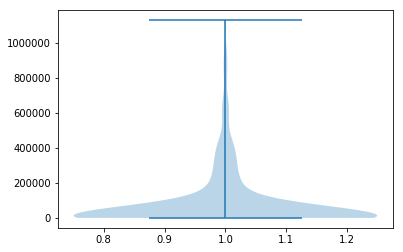

In [149]:
plt.violinplot(target_indices)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f52b4118828>],
 'cbars': <matplotlib.collections.LineCollection at 0x7f52b4118f98>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f52b4118780>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f52b4118cf8>}

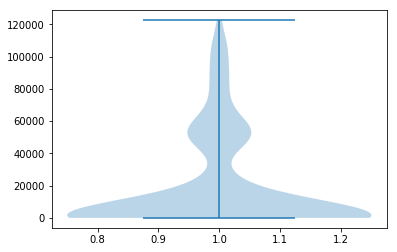

In [163]:
plt.violinplot(target_indices[:-80])

In [32]:
# what if we only use pagerank?
X = test_papers_df[['EF']]
y = test_papers_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

start = timer()
_model = LogisticRegression()
_model.fit(X_train, y_train)
print(format_timespan(timer()-start))

# y_pred_proba = model.predict_proba(X_test)[:, 1]
_y_pred_proba = _model.predict_proba(X)[:, 1]
#y_pred_proba

print(y_pred_proba.shape)

_pred_ranks = pd.Series(_y_pred_proba, index=X.index, name='pred_ranks')
#test_papers_df.join(_pred_ranks).sort_values('pred_ranks', ascending=False).head()



_top_predictions = test_papers_df.join(_pred_ranks).sort_values('pred_ranks', ascending=False).head(len(target_papers_df))

_top_predictions.groupby('target')['Paper_ID'].count()

4.23 seconds
(2613291,)


target
False    388
True       9
Name: Paper_ID, dtype: int64

In [33]:
# what if we only use avg distance?
X = test_papers_df[['avg_distance_to_train']]
y = test_papers_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

start = timer()
_model = LogisticRegression()
_model.fit(X_train, y_train)
print(format_timespan(timer()-start))

# y_pred_proba = model.predict_proba(X_test)[:, 1]
_y_pred_proba = _model.predict_proba(X)[:, 1]
#y_pred_proba

print(y_pred_proba.shape)

_pred_ranks = pd.Series(_y_pred_proba, index=X.index, name='pred_ranks')
#test_papers_df.join(_pred_ranks).sort_values('pred_ranks', ascending=False).head()



_top_predictions = test_papers_df.join(_pred_ranks).sort_values('pred_ranks', ascending=False).head(len(target_papers_df))

_top_predictions.groupby('target')['Paper_ID'].count()

4.6 seconds
(2613291,)


target
False    377
True      20
Name: Paper_ID, dtype: int64

In [34]:
start = timer()
toplevels = test_papers_df.cl.apply(lambda x: x.split(":")[0])
print(format_timespan(timer()-start))

2.39 seconds


In [55]:
toplevels.name = 'toplevel'

In [37]:
toplevels_set = set(toplevels)

In [46]:
start = timer()
tbl = db.tables['clusters_meta_tree']
sq = tbl.select(tbl.c.toplevel_in_tree.in_(toplevels_set))
# r = db.engine.execute(sq).fetchall()
cl_meta = db.read_sql(sq)
print(format_timespan(timer()-start))

/home/jporteno/code/autoreview/venv/lib/python3.5/site-packages/pymysql/cursors.py:165: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


19.19 seconds


In [50]:
cl_meta = cl_meta.set_index('id')

In [82]:
train_papers_df['toplevel'] = train_papers_df.cl.apply(lambda x: x.split(":")[0]).astype(int)

In [83]:
meta_map = cl_meta.set_index('toplevel_in_tree').meta_cl

In [84]:
train_papers_df['cl_meta'] = train_papers_df.toplevel.map(meta_map)

In [87]:
test_papers_df['toplevel'] = toplevels.astype(int)
test_papers_df['cl_meta'] = test_papers_df.toplevel.map(meta_map)

In [89]:
start = timer()
test_papers_df['meta_avg_distance_to_train'] = test_papers_df.cl_meta.apply(avg_distance, cl_group=train_papers_df.cl_meta.tolist())
print(format_timespan(timer()-start))

4 minutes and 10.75 seconds


In [94]:
# logistic regression including meta cl
X = test_papers_df[['EF', 'avg_distance_to_train', 'meta_avg_distance_to_train']]
y = test_papers_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

start = timer()
model_meta = LogisticRegression()
model_meta.fit(X_train, y_train)
print(format_timespan(timer()-start))

# y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_proba_meta = model_meta.predict_proba(X)[:, 1]
#y_pred_proba

print(y_pred_proba_meta.shape)

pred_ranks_meta = pd.Series(y_pred_proba_meta, index=X.index, name='pred_ranks')
#test_papers_df.join(_pred_ranks).sort_values('pred_ranks', ascending=False).head()



top_predictions_meta = test_papers_df.join(pred_ranks_meta).sort_values('pred_ranks', ascending=False).head(len(target_papers_df))

top_predictions_meta.groupby('target')['Paper_ID'].count()

6.54 seconds
(2613291,)


target
False    289
True     108
Name: Paper_ID, dtype: int64

In [105]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y, y_pred_proba))
print(roc_auc_score(y, y_pred_proba_meta))
print(roc_auc_score(y, _y_pred_proba))

0.9553407108497369
0.8686914172329787
0.7952530679672806
